In [1]:
import numpy as np
import sklearn as sk
import sklearn.linear_model as sklm
import sklearn.metrics as skmt
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io
import h5py
import sys
# import pickle # save into bytes file

sys.path.append('../Metric/')
sys.path.append('../../Visualization/')
sys.path.append('../../Data_Preprocessing//')
from Metric import *
from Visualization import *
from Data_Extractor import *
from sklearn.externals import joblib

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load & Construct training & test set:

In [2]:
# Load
path_test_set = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/posneg_topleft_coord_split_8_test"

test_set = h5py.File(path_test_set, 'r')
test_pos_topleft_coord = np.array(test_set['positive_example'])
test_neg_topleft_coord = np.array(test_set['negative_example'])
test_raw_image = np.array(test_set['raw_image'])
test_road_mask = np.array(test_set['road_mask'])
test_set.close()

print(test_raw_image.shape, test_road_mask.shape)

# Construct training & test set
pos_size = test_pos_topleft_coord.shape[0]
neg_size = test_neg_topleft_coord.shape[0]
print("pos=", pos_size, "neg=", neg_size)

(7, 2337, 8091) (2337, 8091)
pos= 43743 neg= 3002535


In [3]:
size = 8

Test_Data = Data_Extractor(test_raw_image, test_road_mask, size,
                           pos_topleft_coord = test_pos_topleft_coord,
                           neg_topleft_coord = test_neg_topleft_coord)

print("pos = ", Test_Data.pos_size, "neg = ", Test_Data.neg_size)

mu =  [ 187.71059516  241.17685028  432.1189087   445.35419263 2449.03433567
 1617.91561837  904.85205398]
pos =  43743 neg =  3002535


In [4]:
# reload model
path_model    = "./Result/motor_trunk_pri_sec_tert_uncl_track/sklearn/sk-SGD_weight_G0_01_p8_e15_r1"
log_classifier = joblib.load(path_model)

Evaluate on test

In [5]:
test_metric = Metric()

for x, y in Test_Data.iterate_data(norm=True):
    x = x.reshape((1, -1))
    
    # record metric
    pred = log_classifier.predict(x)
    test_metric.accumulate(np.array([pred]), np.array([y]))
    
test_metric.print_info()

true_pos  = 23779
false_pos = 1555463
true_neg  = 1447072
false_neg = 19964
size = 3046278
pos_recall    = 0.5436069771163387
pos_precision = 0.015057223655399236
pos_F1        = 0.02930279700674991
neg_recall    = 0.4819500855110765
neg_precision = 0.9863916086585469
neg_F1        = 0.6475216525254884
accuracy      = 0.4828354470603143
balanced_accuracy = 0.5127785313137075


Predict road prob masks

In [11]:
# Predict road prob on CV
pos_class_index = int(np.where(log_classifier.classes_ == 1)[0])
test_pred_road = np.zeros(test_road_mask.shape)
for coord, patch in Test_Data.iterate_raw_image_patches_with_coord(norm=True):
    patch = patch.reshape([1,-1])
    test_pred_road[int(coord[0]+size/2), int(coord[1]+size/2)] = log_classifier.predict_proba(patch)[0, pos_class_index]

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [ ]:
prediction_name = model_name + '_pred.h5'

h5f_file = h5py.File(model_path + prediction_name, 'w')
h5f_file.create_dataset (name='pred_road', data=pred_road)
h5f_file.close()

Load prediction

In [ ]:
# restore prediction 
prediction_name = model_name + '_pred.h5'

h5f_file  = h5py.File(model_path + prediction_name, 'r')
pred_road = np.array(h5f_file['pred_road'])
h5f_file.close()

Analyze pred

0.0 1.0 0.03398173574971001


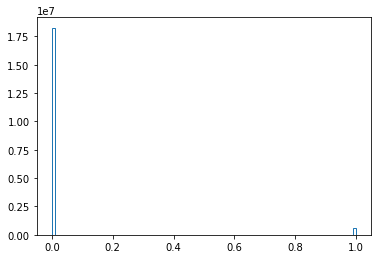

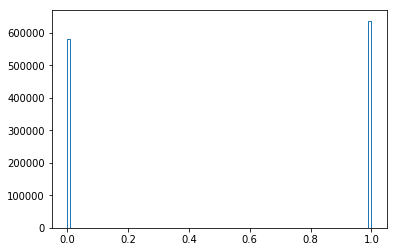

In [12]:
print(pred_road.min(), pred_road.max(), pred_road.mean())
plt.hist(x=pred_road.flatten(), bins=100, histtype='step')
plt.show()
plt.close()
plt.hist(x=pred_road[np.where(pred_road>0)].flatten(), bins=100, histtype='step')
plt.show()
plt.close()

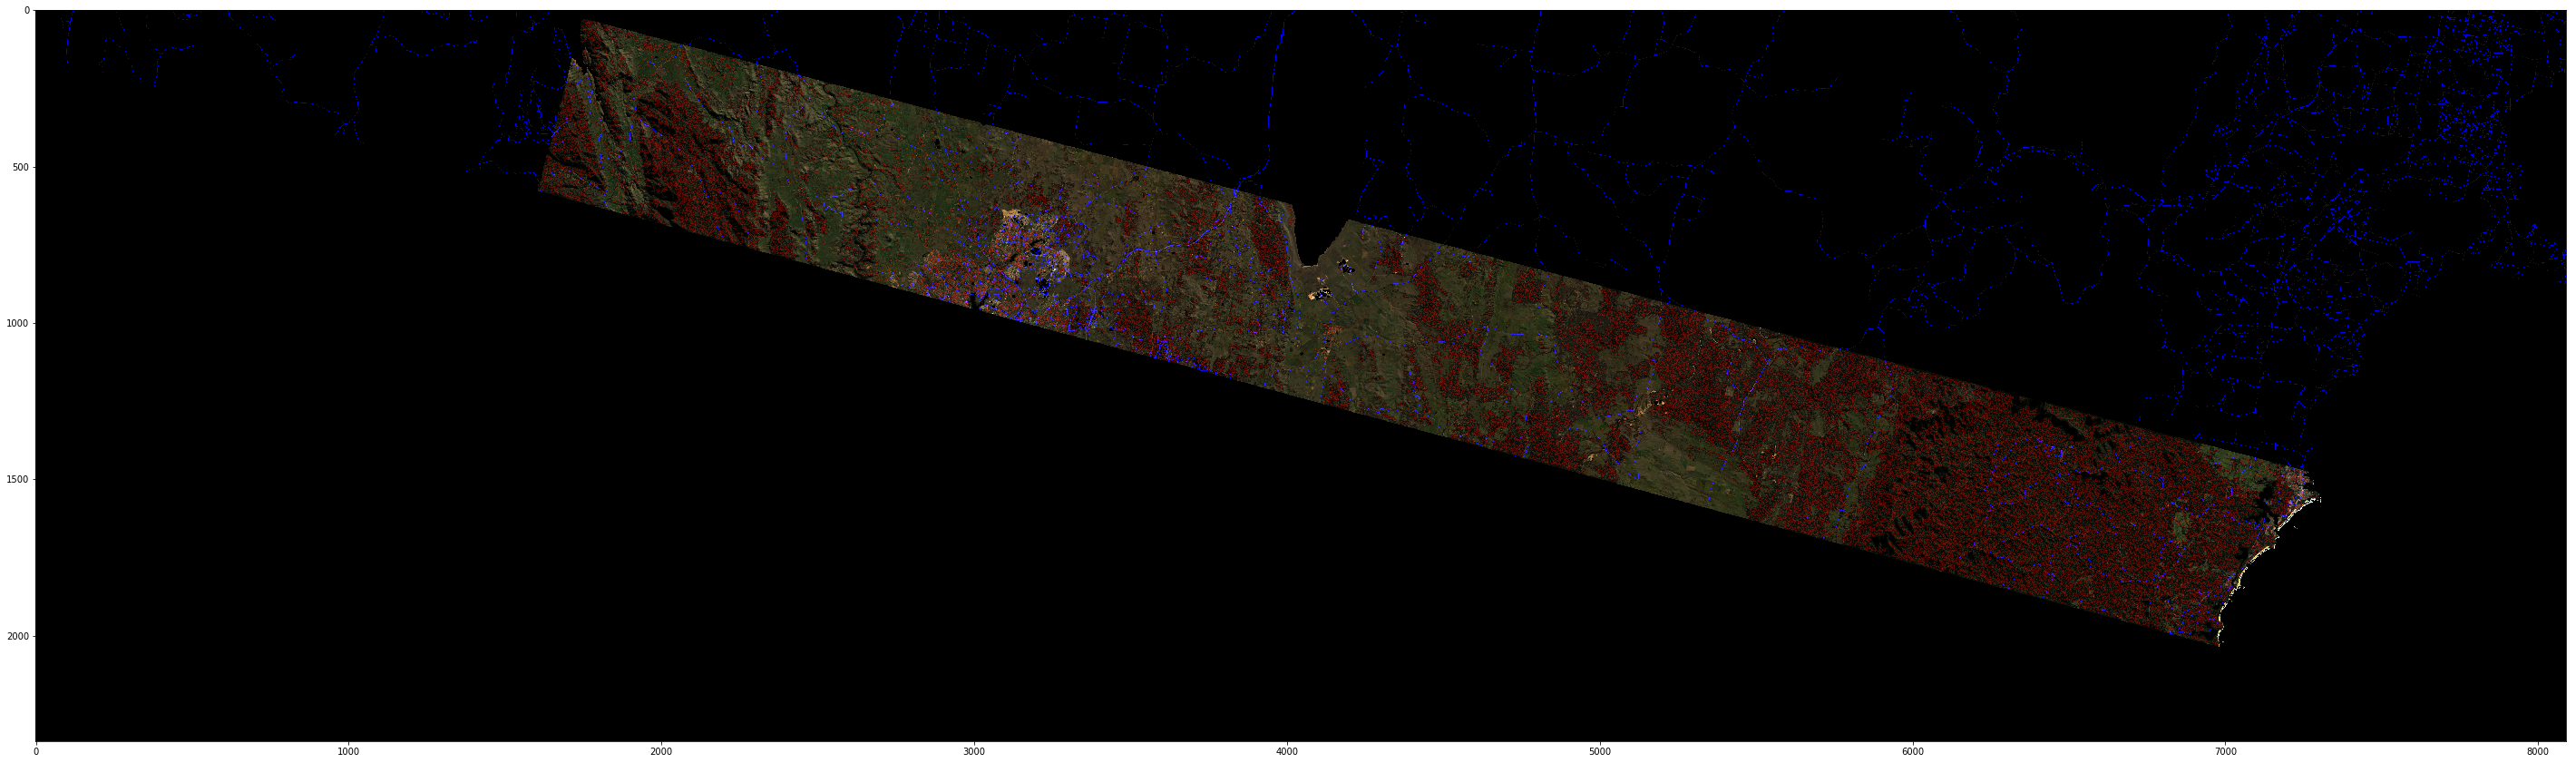

In [14]:
show_pred_prob_with_raw(test_raw_image, pred_road, test_road_mask, pred_weight=0.3, figsize=(50,50), 
                        show_plot=True)
#                         save_path=model_path + 'Analysis/prob_road_on_raw - 0_1.png')

Analyze log pred

In [ ]:
log_pred = -np.log(-pred_road + 1 + 1e-7)
print(log_pred.min(), log_pred.max(), log_pred.mean())

norm_log_pred = (log_pred - log_pred.min()) / (log_pred.max()-log_pred.min())
print(norm_log_pred.min(), norm_log_pred.max(), norm_log_pred.mean())

In [ ]:
show_pred_prob_with_raw(raw_image, norm_log_pred,
                        true_road=road_mask, pred_weight=0.3, figsize=(150,150), show_plot=False,
                        save_path=model_path + 'Analysis/log_prob_on_raw - 0_2.png')

In [ ]:
plt.imshow(np.array([[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]), cmap='hot')
plt.show()
plt.figure(figsize=(100,100))
plt.imshow(pred_road, cmap=plt.get_cmap('hot'))
plt.show()
plt.close()

In [ ]:
plt.imshow(np.array([[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]]), cmap='hot')
plt.show()
plt.figure(figsize=(100,100))
plt.imshow(np.log(pred_road + 1e-9), cmap='hot')
plt.show()
plt.close()